In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [37]:
import implicit
from implicit.als import AlternatingLeastSquares
from scipy.sparce import csr_matrix

In [38]:
from src.models import *
from src.losses import *
from src.utils import *
from src.trainer import MetricTrainer
from src.dataset import PariwiseDataset

In [5]:
DATA = 'samokat'
SIZE = '100k'


if DATA == 'movielens':
    data = load_movielens(SIZE)
    data_train, data_valid, data_test = train_test_split_interations(data, method='last')
elif DATA == 'samokat':
    data = pd.read_csv(f'data/samokat/data_{SIZE}.csv')
    data_train, data_valid, data_test = train_test_split_interations(data, method='random')
    
    
N_USERS = data.user_id.nunique()
N_ITEMS = data.item_id.nunique()
user_sizes = data.groupby('user_id').count().item_id.to_numpy()
item_sizes = data.groupby('item_id').count().user_id.to_numpy()

In [ ]:
cfg = dotdict()
cfg['bs'] = 512
cfg['lr'] = 1e-2
cfg['neg_samples'] = 10
cfg['embedding_dim'] = 256
cfg['margin'] = 0.5
cfg['lam'] = 1
cfg['step_size'] = 10
cfg['max_norm'] = 1
cfg['drop_rate'] = 0
cfg['weighted'] = False

In [25]:
model = 'HyperCML'

train_set = PariwiseDataset(
    data_train, 
    N_USERS, 
    N_ITEMS, 
    neg_samples=cfg.neg_samples, 
    weights=(item_sizes if cfg.weighted else None))

valid_set = PariwiseDataset(data_valid, N_USERS, N_ITEMS, neg_samples=100)
test_set = PariwiseDataset(data_test, N_USERS, N_ITEMS, neg_samples=100)

train_loader = DataLoader(train_set, batch_size=cfg.bs, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=N_USERS, shuffle=False)
test_loader = DataLoader(test_set, batch_size=N_USERS, shuffle=False)


if model == 'CML':
    metric_model = CML(N_USERS, N_ITEMS, embedding_dim=cfg.embedding_dim, dropout_rate=cfg.drop_rate, max_norm=cfg.max_norm)
    metric_criterion = AdditiveLoss(
        nn.TripletMarginLoss(margin=cfg.margin),
        CovarianceLoss(),
        coefficients=[1, cfg.lam]
    )

    metric_trainer = MetricTrainer(metric_model, metric_criterion)
    metric_trainer.optimizer = Adam(metric_trainer.model.parameters(), lr=cfg.lr)
elif model == 'HyperCML':
    manifold = geoopt.PoincareBall(c=1, learnable=True)
    metric_model = HyperCML(
        N_USERS, 
        N_ITEMS, 
        embedding_dim=cfg.embedding_dim, 
        dropout_rate=cfg.drop_rate,
        manifold=manifold, 
        max_norm=cfg.max_norm)
    metric_criterion = AdditiveLoss(
        nn.TripletMarginWithDistanceLoss(margin=cfg.margin, distance_function=manifold.dist),
        DistortionLoss(manifold=manifold),
        coefficients=[1, cfg.lam]
    )

    metric_trainer = MetricTrainer(metric_model, metric_criterion)
    metric_trainer.optimizer = RiemannianAdam(metric_trainer.model.parameters(), lr=cfg.lr)

In [26]:
metric_trainer.fit(train_loader, test_loader, epochs=50, plot=False, validate_every=50)
#fig = metric_trainer.plot_embeddings(item_sizes=item_sizes, user_sizes=user_sizes)
#figname = next(it)
#plt.savefig(f'images/{figname}')
full_hr = full_hit_rate(metric_trainer, valid_set, data_train)

row = ','.join(map(str, 
    [
        model, 
        cfg.embedding_dim, 
        cfg.margin, 
        cfg.lam, 
        cfg.lr,
        metric_trainer.logs['valid_epoch_loss'][-1], 
        int(metric_trainer.logs['valid_step_hits'][-1]), 
        metric_trainer.logs['valid_epoch_hitrate'][-1],
        metric_trainer.logs['valid_epoch_ndcg'][-1],
        full_hr,
        #figname
    ]
))

with open('logs_test.txt', 'a') as f:
    f.write(row)
    f.write('\n')

print(row)

  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 1


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.3775553079175697
--------------------------------------------------------------------------------
epoch: 2


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.2925823908201686
--------------------------------------------------------------------------------
epoch: 3


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.283615062374095
--------------------------------------------------------------------------------
epoch: 4


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.2741375343961865
--------------------------------------------------------------------------------
epoch: 5


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.258916033500152
--------------------------------------------------------------------------------
epoch: 6


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.2410322359095067
--------------------------------------------------------------------------------
epoch: 7


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.222019251728557
--------------------------------------------------------------------------------
epoch: 8


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.2030522174236036
--------------------------------------------------------------------------------
epoch: 9


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.1861419939869986
--------------------------------------------------------------------------------
epoch: 10


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.17029130521245
--------------------------------------------------------------------------------
epoch: 11


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.15637891080367
--------------------------------------------------------------------------------
epoch: 12


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.144154990530763
--------------------------------------------------------------------------------
epoch: 13


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.13286616290427
--------------------------------------------------------------------------------
epoch: 14


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.12304026793435
--------------------------------------------------------------------------------
epoch: 15


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.114267734956991
--------------------------------------------------------------------------------
epoch: 16


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.1060117177314157
--------------------------------------------------------------------------------
epoch: 17


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.098693760277713
--------------------------------------------------------------------------------
epoch: 18


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.09212227391947
--------------------------------------------------------------------------------
epoch: 19


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0860767077401046
--------------------------------------------------------------------------------
epoch: 20


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0802182077737377
--------------------------------------------------------------------------------
epoch: 21


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0748003739961156
--------------------------------------------------------------------------------
epoch: 22


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.07025953237923
--------------------------------------------------------------------------------
epoch: 23


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.065678793722422
--------------------------------------------------------------------------------
epoch: 24


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.062235391576877
--------------------------------------------------------------------------------
epoch: 25


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.059053226291197
--------------------------------------------------------------------------------
epoch: 26


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0560246025704587
--------------------------------------------------------------------------------
epoch: 27


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0538999497578407
--------------------------------------------------------------------------------
epoch: 28


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0519960800390593
--------------------------------------------------------------------------------
epoch: 29


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.05018325126608
--------------------------------------------------------------------------------
epoch: 30


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.048964122203008
--------------------------------------------------------------------------------
epoch: 31


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.047935263648707
--------------------------------------------------------------------------------
epoch: 32


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0468143280888103
--------------------------------------------------------------------------------
epoch: 33


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0458171355162618
--------------------------------------------------------------------------------
epoch: 34


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.045053695508947
--------------------------------------------------------------------------------
epoch: 35


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.044297687670323
--------------------------------------------------------------------------------
epoch: 36


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0435603638594064
--------------------------------------------------------------------------------
epoch: 37


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.042999036649135
--------------------------------------------------------------------------------
epoch: 38


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0422862562209523
--------------------------------------------------------------------------------
epoch: 39


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0418489066718135
--------------------------------------------------------------------------------
epoch: 40


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0414068698883057
--------------------------------------------------------------------------------
epoch: 41


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0407755399873744
--------------------------------------------------------------------------------
epoch: 42


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0401684676165357
--------------------------------------------------------------------------------
epoch: 43


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.039965136513036
--------------------------------------------------------------------------------
epoch: 44


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.039819553884536
--------------------------------------------------------------------------------
epoch: 45


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.039470226976884
--------------------------------------------------------------------------------
epoch: 46


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0389724139767793
--------------------------------------------------------------------------------
epoch: 47


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0387695821792042
--------------------------------------------------------------------------------
epoch: 48


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0384352781385653
--------------------------------------------------------------------------------
epoch: 49


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.038159560158615
--------------------------------------------------------------------------------
epoch: 50


  0%|          | 0/191 [00:00<?, ?it/s]

train_loss: 2.0380158187207127


  0%|          | 0/1 [00:00<?, ?it/s]

valid_loss: 2.252941370010376
valid_hitrate: 1348/2447
valid_ndcg: 762.82/2447
--------------------------------------------------------------------------------
HyperCML,256,0.5,1,0.01,2.252941370010376,1348,0.5508786268900695,0.3117366489898345,0.07029015120555783


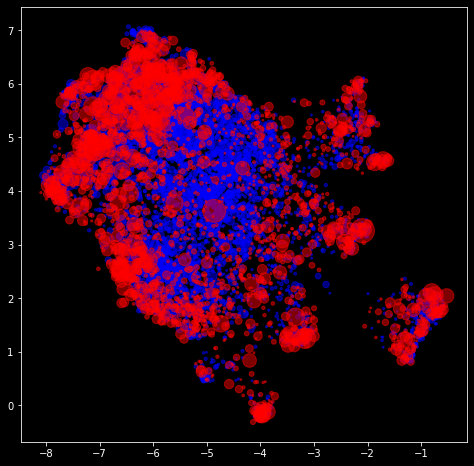

In [23]:
metric_trainer.plot_embeddings(item_sizes=item_sizes, user_sizes=user_sizes, algorithm='UMAP');

In [18]:
DATA = 'samokat'
SIZE = '100k'

if DATA == 'movielens':
    data = load_movielens(path='data/movielens', version=SIZE)
    data_train, data_valid, data_test = train_test_split_interations(data, method='last')
elif DATA == 'samokat':
    data = pd.read_csv(f'data/samokat/data_{SIZE}.csv')
    data_train, data_valid, data_test = train_test_split_interations(data, method='random')
    
N_USERS = data.user_id.nunique()
N_ITEMS = data.item_id.nunique()
user_sizes = data.groupby('user_id').count().item_id.to_numpy()
item_sizes = data.groupby('item_id').count().user_id.to_numpy()

In [19]:
csr_data_train = csr_matrix((np.ones(data_train.shape[0]), (data_train.user_id, data_train.item_id)), shape=(N_USERS, N_ITEMS))
valid_ids = data_valid['item_id'].to_numpy()[:, None]
test_ids = data_test['item_id'].to_numpy()[:, None]

In [20]:
model = AlternatingLeastSquares(factors=16, regularization=0, iterations=100, random_state=1)
model.fit(csr_data_train)

D:\Work\samokat\venv\lib\site-packages\implicit\utils.py:26: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
def _hit_rate_util(ids, scores, valid_ids, i, size=100):
    ids_1 = ids[i]
    scores_1 = scores[i]
    valid_id_1 = valid_ids[i][0]
    rated_scores = scores_1[scores_1>-1e+10]
    rated_ids = ids_1[scores_1>-1e+10] # filter already rated
    valid_index = np.where(rated_ids==valid_id_1)[0][0] # save valid one
    valid_id_ = rated_ids[valid_index]
    valid_score_ = rated_scores[valid_index]
    rated_ids_ = rated_ids[np.arange(len(rated_ids))!=valid_index] # remove valid one
    rated_scores_ = rated_scores[np.arange(len(rated_scores))!=valid_index]
    selected_indices = np.random.choice(len(rated_ids_), size=size, replace=False) # chose 100 random
    selected_ids = rated_ids_[selected_indices]
    selected_scores = rated_scores_[selected_indices]
    selected_ids_v = np.append(selected_ids, valid_id_)
    selected_scores_v = np.append(selected_scores, valid_score_)
    return valid_id_ in selected_ids_v[selected_scores_v.argsort()[::-1]][:10]

def hit_rate(ids, scores, valid_ids):
    hits = 0
    for i in range(valid_ids.shape[0]):
        hits += _hit_rate_util(ids, scores, valid_ids, i)
    return hits

In [22]:
ids, scores = model.recommend(np.arange(N_USERS), csr_data_train, N=N_ITEMS, filter_already_liked_items=True)
hits = hit_rate(ids, scores, valid_ids)
print(hits)
print(hits / N_USERS)

1242
0.5075602778912954


In [23]:
results_256 = []
for i in np.linspace(-5, 5, num=41):
    reg = 10**i
    print(f'regularization = 10^{i}:')
    model = AlternatingLeastSquares(factors=256, regularization=reg, iterations=100, random_state=1)
    model.fit(csr_data_train)
    ids, scores = model.recommend(np.arange(N_USERS), csr_data_train, N=N_ITEMS, filter_already_liked_items=True)
    hits = hit_rate(ids, scores, valid_ids)
    results_256.append(hits)
    print('hit_rate =', hits / N_USERS)
    print('-'*80)
    
results_64 = []
for i in np.linspace(-5, 5, num=41):
    reg = 10**i
    print(f'regularization = 10^{i}:')
    model = AlternatingLeastSquares(factors=64, regularization=reg, iterations=100, random_state=1)
    model.fit(csr_data_train)
    ids, scores = model.recommend(np.arange(N_USERS), csr_data_train, N=N_ITEMS, filter_already_liked_items=True)
    hits = hit_rate(ids, scores, valid_ids)
    results_64.append(hits)
    print('hit_rate =', hits / N_USERS)
    print('-'*80)
    
results_16 = []
for i in np.linspace(-5, 5, num=41):
    reg = 10**i
    print(f'regularization = 10^{i}:')
    model = AlternatingLeastSquares(factors=16, regularization=reg, iterations=100, random_state=1)
    model.fit(csr_data_train)
    ids, scores = model.recommend(np.arange(N_USERS), csr_data_train, N=N_ITEMS, filter_already_liked_items=True)
    hits = hit_rate(ids, scores, valid_ids)
    results_16.append(hits)
    print('hit_rate =', hits / N_USERS)
    print('-'*80)

regularization = 10^-5.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.38577850429096855
--------------------------------------------------------------------------------
regularization = 10^-4.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.38455251328156925
--------------------------------------------------------------------------------
regularization = 10^-4.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.38577850429096855
--------------------------------------------------------------------------------
regularization = 10^-4.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.38577850429096855
--------------------------------------------------------------------------------
regularization = 10^-4.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.3870044953003678
--------------------------------------------------------------------------------
regularization = 10^-3.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.38577850429096855
--------------------------------------------------------------------------------
regularization = 10^-3.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.38455251328156925
--------------------------------------------------------------------------------
regularization = 10^-3.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.38659583163056804
--------------------------------------------------------------------------------
regularization = 10^-3.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.38332652227217
--------------------------------------------------------------------------------
regularization = 10^-2.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.38291785860237026
--------------------------------------------------------------------------------
regularization = 10^-2.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.3861871679607683
--------------------------------------------------------------------------------
regularization = 10^-2.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.3812832039231712
--------------------------------------------------------------------------------
regularization = 10^-2.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.38659583163056804
--------------------------------------------------------------------------------
regularization = 10^-1.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.380057212913772
--------------------------------------------------------------------------------
regularization = 10^-1.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.3878218226399673
--------------------------------------------------------------------------------
regularization = 10^-1.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.38577850429096855
--------------------------------------------------------------------------------
regularization = 10^-1.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.38332652227217
--------------------------------------------------------------------------------
regularization = 10^-0.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.3861871679607683
--------------------------------------------------------------------------------
regularization = 10^-0.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.39476910502656315
--------------------------------------------------------------------------------
regularization = 10^-0.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.3931344503473641
--------------------------------------------------------------------------------
regularization = 10^0.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.3931344503473641
--------------------------------------------------------------------------------
regularization = 10^0.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4021250510829587
--------------------------------------------------------------------------------
regularization = 10^0.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.41479362484675114
--------------------------------------------------------------------------------
regularization = 10^0.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.448304045770331
--------------------------------------------------------------------------------
regularization = 10^1.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5018389865140989
--------------------------------------------------------------------------------
regularization = 10^1.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.526767470371884
--------------------------------------------------------------------------------
regularization = 10^1.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.428279525950143
--------------------------------------------------------------------------------
regularization = 10^1.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4168369431957499
--------------------------------------------------------------------------------
regularization = 10^2.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4213322435635472
--------------------------------------------------------------------------------
regularization = 10^2.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.1834899877400899
--------------------------------------------------------------------------------
regularization = 10^2.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.09562729873314263
--------------------------------------------------------------------------------
regularization = 10^2.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.2214957090314671
--------------------------------------------------------------------------------
regularization = 10^3.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.03841438496117695
--------------------------------------------------------------------------------
regularization = 10^3.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.21945239068246833
--------------------------------------------------------------------------------
regularization = 10^3.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.3391908459337965
--------------------------------------------------------------------------------
regularization = 10^3.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.37351859419697586
--------------------------------------------------------------------------------
regularization = 10^4.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.09848794442174091
--------------------------------------------------------------------------------
regularization = 10^4.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4205149162239477
--------------------------------------------------------------------------------
regularization = 10^4.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.41888026154474867
--------------------------------------------------------------------------------
regularization = 10^4.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.21945239068246833
--------------------------------------------------------------------------------
regularization = 10^5.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.0723334695545566
--------------------------------------------------------------------------------
regularization = 10^-5.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.45811197384552516
--------------------------------------------------------------------------------
regularization = 10^-4.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.45974662852472414
--------------------------------------------------------------------------------
regularization = 10^-4.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4564773191663261
--------------------------------------------------------------------------------
regularization = 10^-4.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.46178994687372293
--------------------------------------------------------------------------------
regularization = 10^-4.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.46505925623212097
--------------------------------------------------------------------------------
regularization = 10^-3.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.46710257458111976
--------------------------------------------------------------------------------
regularization = 10^-3.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.46505925623212097
--------------------------------------------------------------------------------
regularization = 10^-3.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.46873722926031874
--------------------------------------------------------------------------------
regularization = 10^-3.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.46097261953412344
--------------------------------------------------------------------------------
regularization = 10^-2.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.45688598283612586
--------------------------------------------------------------------------------
regularization = 10^-2.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4662852472415202
--------------------------------------------------------------------------------
regularization = 10^-2.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4613812832039232
--------------------------------------------------------------------------------
regularization = 10^-2.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.46056395586432364
--------------------------------------------------------------------------------
regularization = 10^-1.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.45974662852472414
--------------------------------------------------------------------------------
regularization = 10^-1.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4572946465059256
--------------------------------------------------------------------------------
regularization = 10^-1.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4601552921945239
--------------------------------------------------------------------------------
regularization = 10^-1.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4662852472415202
--------------------------------------------------------------------------------
regularization = 10^-0.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4564773191663261
--------------------------------------------------------------------------------
regularization = 10^-0.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4585206375153249
--------------------------------------------------------------------------------
regularization = 10^-0.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.45688598283612586
--------------------------------------------------------------------------------
regularization = 10^0.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.46873722926031874
--------------------------------------------------------------------------------
regularization = 10^0.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.468328565590519
--------------------------------------------------------------------------------
regularization = 10^0.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4711892112791173
--------------------------------------------------------------------------------
regularization = 10^0.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4818144666939109
--------------------------------------------------------------------------------
regularization = 10^1.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5002043318348999
--------------------------------------------------------------------------------
regularization = 10^1.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5234981610134859
--------------------------------------------------------------------------------
regularization = 10^1.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.43277482631794034
--------------------------------------------------------------------------------
regularization = 10^1.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.423375561912546
--------------------------------------------------------------------------------
regularization = 10^2.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4205149162239477
--------------------------------------------------------------------------------
regularization = 10^2.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.2496935022476502
--------------------------------------------------------------------------------
regularization = 10^2.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.09644462607274214
--------------------------------------------------------------------------------
regularization = 10^2.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.17981201471189212
--------------------------------------------------------------------------------
regularization = 10^3.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.044135676338373515
--------------------------------------------------------------------------------
regularization = 10^3.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.04004903964037597
--------------------------------------------------------------------------------
regularization = 10^3.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4115243154883531
--------------------------------------------------------------------------------
regularization = 10^3.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.12627707396812424
--------------------------------------------------------------------------------
regularization = 10^4.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.17736003269309358
--------------------------------------------------------------------------------
regularization = 10^4.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4213322435635472
--------------------------------------------------------------------------------
regularization = 10^4.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4176542705353494
--------------------------------------------------------------------------------
regularization = 10^4.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.056804250102165915
--------------------------------------------------------------------------------
regularization = 10^5.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.12178177360032694
--------------------------------------------------------------------------------
regularization = 10^-5.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5006129955046996
--------------------------------------------------------------------------------
regularization = 10^-4.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5112382509194933
--------------------------------------------------------------------------------
regularization = 10^-4.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5059256232120964
--------------------------------------------------------------------------------
regularization = 10^-4.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5067429505516959
--------------------------------------------------------------------------------
regularization = 10^-4.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5063342868818962
--------------------------------------------------------------------------------
regularization = 10^-3.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5042909685328975
--------------------------------------------------------------------------------
regularization = 10^-3.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5091949325704945
--------------------------------------------------------------------------------
regularization = 10^-3.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5038823048630977
--------------------------------------------------------------------------------
regularization = 10^-3.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5010216591744994
--------------------------------------------------------------------------------
regularization = 10^-2.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5063342868818962
--------------------------------------------------------------------------------
regularization = 10^-2.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5104209235798938
--------------------------------------------------------------------------------
regularization = 10^-2.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5083776052308949
--------------------------------------------------------------------------------
regularization = 10^-2.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5075602778912954
--------------------------------------------------------------------------------
regularization = 10^-1.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5002043318348999
--------------------------------------------------------------------------------
regularization = 10^-1.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5026563138536984
--------------------------------------------------------------------------------
regularization = 10^-1.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5010216591744994
--------------------------------------------------------------------------------
regularization = 10^-1.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5071516142214957
--------------------------------------------------------------------------------
regularization = 10^-0.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5083776052308949
--------------------------------------------------------------------------------
regularization = 10^-0.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.505108295872497
--------------------------------------------------------------------------------
regularization = 10^-0.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5145075602778912
--------------------------------------------------------------------------------
regularization = 10^0.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5046996322026972
--------------------------------------------------------------------------------
regularization = 10^0.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5096035962402943
--------------------------------------------------------------------------------
regularization = 10^0.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.513281569268492
--------------------------------------------------------------------------------
regularization = 10^0.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5124642419288925
--------------------------------------------------------------------------------
regularization = 10^1.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5140988966080915
--------------------------------------------------------------------------------
regularization = 10^1.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.5153248876174908
--------------------------------------------------------------------------------
regularization = 10^1.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.42991418062934206
--------------------------------------------------------------------------------
regularization = 10^1.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.42255823457294645
--------------------------------------------------------------------------------
regularization = 10^2.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.42868818961994276
--------------------------------------------------------------------------------
regularization = 10^2.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.16673477727829997
--------------------------------------------------------------------------------
regularization = 10^2.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.13240702901512055
--------------------------------------------------------------------------------
regularization = 10^2.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.04168369431957499
--------------------------------------------------------------------------------
regularization = 10^3.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.09440130772374336
--------------------------------------------------------------------------------
regularization = 10^3.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.03351042092357989
--------------------------------------------------------------------------------
regularization = 10^3.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4160196158561504
--------------------------------------------------------------------------------
regularization = 10^3.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.03555373927257867
--------------------------------------------------------------------------------
regularization = 10^4.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.3011851246424193
--------------------------------------------------------------------------------
regularization = 10^4.25:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.423375561912546
--------------------------------------------------------------------------------
regularization = 10^4.5:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.4152022885165509
--------------------------------------------------------------------------------
regularization = 10^4.75:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.06783816918675929
--------------------------------------------------------------------------------
regularization = 10^5.0:


  0%|          | 0/100 [00:00<?, ?it/s]

hit_rate = 0.17940335104209235
--------------------------------------------------------------------------------


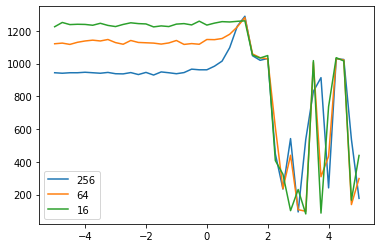

In [53]:
plt.plot(np.linspace(-5, 5, num=41), results_256, label='256')
plt.plot(np.linspace(-5, 5, num=41), results_64, label='64')
plt.plot(np.linspace(-5, 5, num=41), results_16, label='16')
plt.legend()

In [29]:
max(results_64) / N_USERS

0.5234981610134859